# CNN for Image Denoising

Authors:
- Giorgio Daneri
- Daniele Ferrario
- Luca Guffanti

## GPU implementation
We used Jax capabilities to run the code on the GPU, especially the optimized version of the convolution offered by the lax module. This module offers primitive operations that are at the base of other modules, such as jax.numpy. Specifically, we used the `lax.conv_general_dilated` function, which is a general n-dimensional convolution operator, with optional dilation.
First of all, we need to reshape the input image, by adding two extra dimenions at the beginning, which are the batch size and the number of channels. The input image is a grayscale image, so the number of channels is 1. The output image is also a grayscale image, so again the number of channels is 1. The batch size is 1, so both the input and output images have shape `(1, 1, 28, 28)`.
The same operation is applied to the kernel, thus changing its shape to `(1, 1, 3, 3)`. We use a stride of 1 to perform the convolution, since we should not skip any pixel during the denoising process. The padding scheme is 'SAME', since the size of the output image is the same as the input image. Of course, we do not want any dilation. Lastly, we reshape the output tensor to have the original shape of the input.
The convolution operation implemented in the lax module proved way more efficient than the hand written one, since it exploits the parallel capabilities of the underlying architecture. The problem is that the same function actually runs faster on the CPU than on the GPU. This is probably due to the fact that the overhead of moving the data to the GPU is higher than the time saved by the parallel computation. Moreover, the problem size is very small, hence why computing on the GPU may be overkill for such an operation. JAX handles memory allocation and data movement to the device internally, so it is sufficient to set up the environment variables relative to the NVIDIA and CUDA libraries. Overall, running the code on the CPU proved to be 1.6 times faster than running it on the GPU. Nontheless, we compared the execution times of the original implementation with the new one run on the GPU.

## Performance Tests
First of all, let us note that the input size is always a single 28x28 image, which does not provide a great deal of parallelization per se. The original version is very slow, hence why we did not perform the simulation multiple times. Since the execution times are very high, the standard deviation is expected to be very low. For the simulations of the accelerated versions, we performed 30 runs for each number of iterations, and we computed the mean and the standard deviation of the execution times. The results are shown in the table below. 
Note that we did not measure the time to fetch the image from the MNIST dataset, the time to apply salt & pepper noise to it, nor the time to produce and write the plot to a file. These operations are not of our interest and pollute the performance comparisons of the CNN training and the image denoising afterwards. 

Moreover, we did not simulate the execution time for input size 10000 on the original version, since it would have taken too much time. We can still extrapolate it by the means of linear interpolation with the data that we have, leading it to be around 52 000 seconds, i.e. 867 minutes or 14.4 hours. This is a rough estimate, since the execution time is not perfectly linear with respect to the input size, but it gives an idea of the huge difference in performance between the two versions.

Let us evaluate the performance of the accelerated implementation with respect to increasing number of training iterations , as well as its speedup with respect to the original version. The results prove that the complexity of the training operation is linear in the number of epochs, as expected.

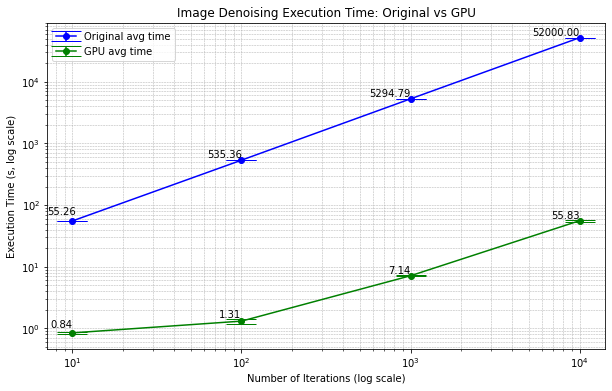

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# load the simulation data
cpu_times_10 = np.loadtxt("results/cpu_time_10.txt")
gpu_times_10 = np.loadtxt("results/gpu_time_10.txt")
# Calculate statistics
cpu_avg_10 = np.mean(cpu_times_10)
cpu_std_10 = np.std(cpu_times_10)
gpu_avg_10 = np.mean(gpu_times_10)
gpu_std_10 = np.std(gpu_times_10)
iterations = np.arange(1, len(cpu_times_10) + 1)

# same for 100 iterations
cpu_times_100 = np.loadtxt("results/cpu_time_100.txt")
gpu_times_100 = np.loadtxt("results/gpu_time_100.txt")
cpu_avg_100 = np.mean(cpu_times_100)
cpu_std_100 = np.std(cpu_times_100)
gpu_avg_100 = np.mean(gpu_times_100)
gpu_std_100 = np.std(gpu_times_100)

# same for 1000 iterations
gpu_times_1000 = np.loadtxt("results/gpu_time_1000.txt")
cpu_avg_1000 = np.loadtxt("results/cpu_time_1000.txt")
cpu_std_1000 = 0
gpu_avg_1000 = np.mean(gpu_times_1000)
gpu_std_1000 = np.std(gpu_times_1000)

# same for 10000 iterations
gpu_times_10000 = np.loadtxt("results/gpu_time_10000.txt")
cpu_avg_10000 = 52000
cpu_std_10000 = 0
gpu_avg_10000 = np.mean(gpu_times_10000)
gpu_std_10000 = np.std(gpu_times_10000)

# prepare data for plotting
iterations = np.array([10, 100, 1000, 10000])
cpu_avg = np.array([cpu_avg_10, cpu_avg_100, cpu_avg_1000, cpu_avg_10000])
cpu_std = np.array([cpu_std_10, cpu_std_100, cpu_std_1000, cpu_std_10000])
gpu_avg = np.array([gpu_avg_10, gpu_avg_100, gpu_avg_1000, gpu_avg_10000])
gpu_std = np.array([gpu_std_10, gpu_std_100, gpu_std_1000, gpu_std_10000])

plt.figure(figsize=(10, 6))
plt.errorbar(iterations, cpu_avg, yerr=cpu_std, fmt='-o', label='Original avg time', capsize=15, color='blue')
plt.errorbar(iterations, gpu_avg, yerr=gpu_std, fmt='-o', label='GPU avg time', capsize=15, color='green')

# annotate the mean execution times
for i in range(len(iterations)):
    plt.text(iterations[i] + 0.5, cpu_avg[i] + 10, f"{cpu_avg[i]:.2f}", ha='right', va='bottom')
    plt.text(iterations[i], gpu_avg[i] + 0.1, f"{gpu_avg[i]:.2f}", ha='right', va='bottom')

# use logarithmic scales for better readability
plt.xscale('log')
plt.yscale('log')
plt.title("Image Denoising Execution Time: Original vs GPU")
plt.xlabel("Number of Iterations (log scale)")
plt.ylabel("Execution Time (s, log scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


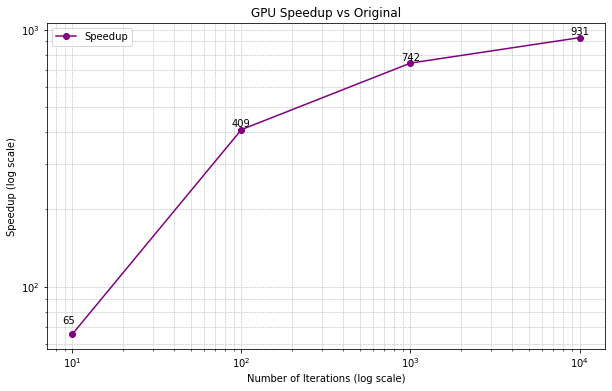

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the simulation data
cpu_times_10 = np.loadtxt("results/cpu_time_10.txt")
gpu_times_10 = np.loadtxt("results/gpu_time_10.txt")

# Calculate statistics for 10 iterations
cpu_avg_10 = np.mean(cpu_times_10)
cpu_std_10 = np.std(cpu_times_10)
gpu_avg_10 = np.mean(gpu_times_10)
gpu_std_10 = np.std(gpu_times_10)

# For 100 iterations
cpu_times_100 = np.loadtxt("results/cpu_time_100.txt")
gpu_times_100 = np.loadtxt("results/gpu_time_100.txt")
cpu_avg_100 = np.mean(cpu_times_100)
cpu_std_100 = np.std(cpu_times_100)
gpu_avg_100 = np.mean(gpu_times_100)
gpu_std_100 = np.std(gpu_times_100)

# For 1000 iterations
gpu_times_1000 = np.loadtxt("results/gpu_time_1000.txt")
cpu_avg_1000 = np.loadtxt("results/cpu_time_1000.txt")
cpu_std_1000 = 0     
gpu_avg_1000 = np.mean(gpu_times_1000)
gpu_std_1000 = np.std(gpu_times_1000)

# same for 10000 iterations
gpu_times_10000 = np.loadtxt("results/gpu_time_10000.txt")
cpu_avg_10000 = 52000
cpu_std_10000 = 0
gpu_avg_10000 = np.mean(gpu_times_10000)
gpu_std_10000 = np.std(gpu_times_10000)

# Prepare data for plotting
iterations = np.array([10, 100, 1000, 10000])
cpu_avg = np.array([cpu_avg_10, cpu_avg_100, cpu_avg_1000, cpu_avg_10000])
cpu_std = np.array([cpu_std_10, cpu_std_100, cpu_std_1000, cpu_std_10000])
gpu_avg = np.array([gpu_avg_10, gpu_avg_100, gpu_avg_1000, gpu_avg_10000])
gpu_std = np.array([gpu_std_10, gpu_std_100, gpu_std_1000, gpu_std_10000])

# compute speedup
speedup = cpu_avg / gpu_avg
plt.figure(figsize=(10, 6))
plt.plot(iterations, speedup, '-o', label='Speedup', color='purple')
# annotate speedup values
for i in range(len(iterations)):
    plt.text(iterations[i] - 0.5, speedup[i] + 5, f"{speedup[i]:.0f}", ha='center', va='bottom')

# use logarithmic scales for better readability
plt.xscale('log')
plt.yscale('log')
plt.title("GPU Speedup vs Original")
plt.xlabel("Number of Iterations (log scale)")
plt.ylabel("Speedup (log scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Visual Results
Let us compare the different denoised images to assess how well the CNN is working. Actually, we observe an increase in the blur of the image as the number of iterations increase. We could argue that the CNN is working like an averaging filter, which is not the best filter to deal with salt and pepper noise. The ideal one would be a median filter, which excludes outliers from the computation of the new intensity values. Nonetheless, the CNN is able to remove the noise from the image, but the results are decent only for a number of iterations greater than 1000. 
We also show how the loss is reduced during the training phase, which is a good indicator of the convergence of the CNN. The loss is computed as the mean squared error between the denoised image and the original one.

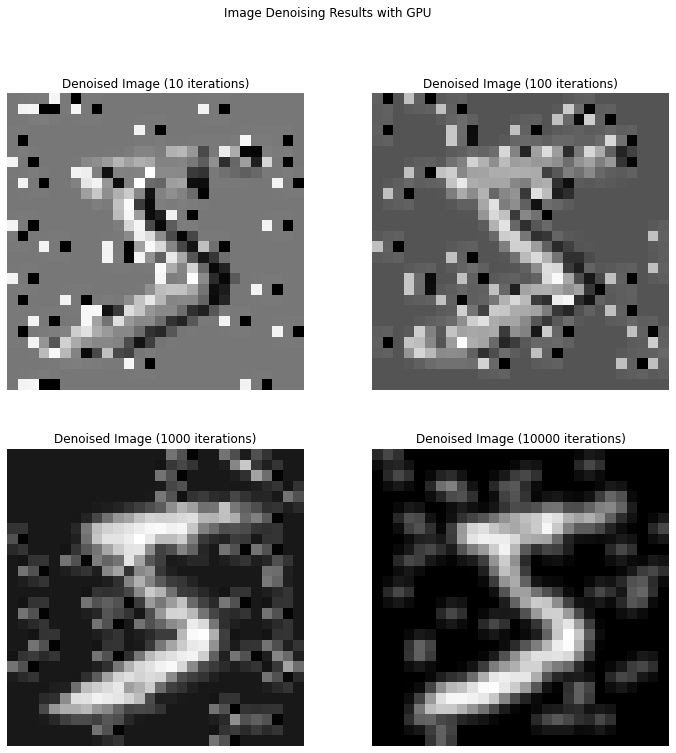

In [ ]:
# load results/gpu_denoised_{num_iterations}.npy
import numpy as np
import matplotlib.pyplot as plt

# Load the denoised image
denoised_10 = np.load("results/gpu_denoised_10.npy")
denoised_100 = np.load("results/gpu_denoised_100.npy")
denoised_1000 = np.load("results/gpu_denoised_1000.npy")
denoised_10000 = np.load("results/gpu_denoised_10000.npy")

# plot the four images in 2 rows and 2 columns
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(denoised_10, cmap='gray')
plt.title("Denoised Image (10 iterations)")
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(denoised_100, cmap='gray')
plt.title("Denoised Image (100 iterations)")
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(denoised_1000, cmap='gray')
plt.title("Denoised Image (1000 iterations)")
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(denoised_10000, cmap='gray')
plt.title("Denoised Image (10000 iterations)")
plt.axis('off')
plt.suptitle("Image Denoising Results with GPU")
plt.show()

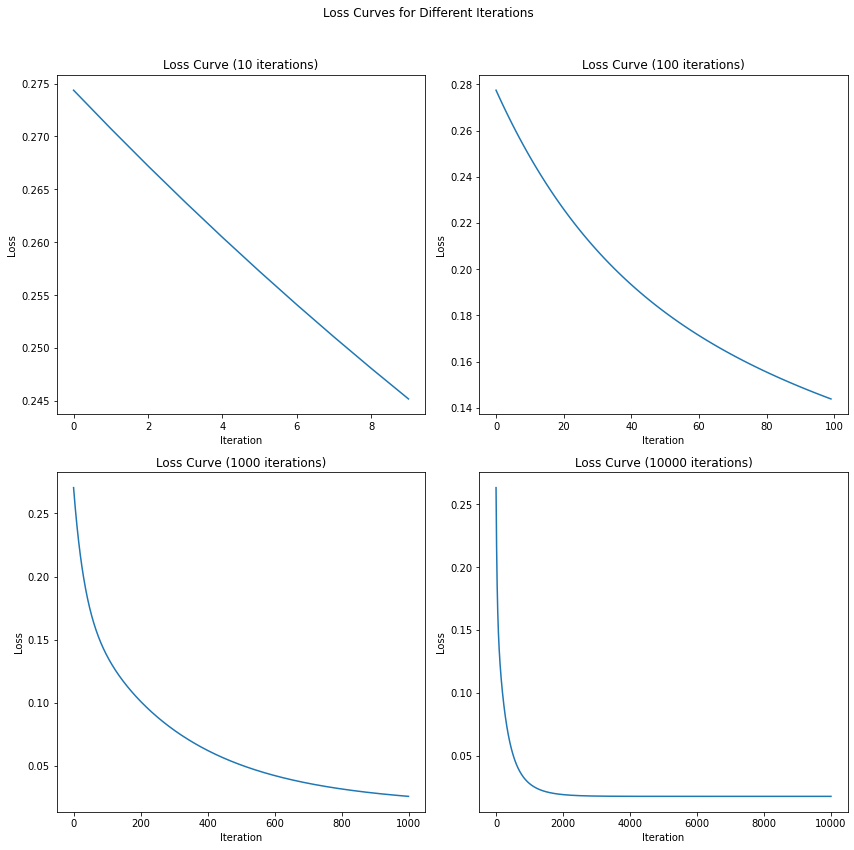

In [13]:
# Load the loss data
losses_10 = np.load("results/gpu_losses_10.npy")
losses_100 = np.load("results/gpu_losses_100.npy")
losses_1000 = np.load("results/gpu_losses_1000.npy")
losses_10000 = np.load("results/gpu_losses_10000.npy")

# plot the four images in 2 rows and 2 columns
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(losses_10)
plt.title("Loss Curve (10 iterations)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(2, 2, 2)
plt.plot(losses_100)
plt.title("Loss Curve (100 iterations)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(2, 2, 3)
plt.plot(losses_1000)
plt.title("Loss Curve (1000 iterations)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(2, 2, 4)
plt.plot(losses_10000)
plt.title("Loss Curve (10000 iterations)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.suptitle("Loss Curves for Different Iterations")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Parallel Stochastic Gradient Descent
Using MPI we implemented a Parallel Stochastic Gradient Descent. 
1. Rank $0$ loads the elements from the MNIST dataset.
2. Rank $0$ introduces salt and pepper noise.
3. Rank $0$ distributes evenly the original and noised images to all available ranks.
4. All ranks execute the training procedure, gathering gradients and losses after each epoch, averaging them to 
update the kernel.

To make the implementation effective, we chose to increase the number of noised images.

To execute the code, either run with `mpiexec` the file `src/P3_mpi.py`, specifying as a command line parameter the number of image that you want in the dataset, or launch the slurm batch job by executing
```bash
sbatch mpi_job.sh
```
after modifying its contents to choose the number of processes, nodes, images to be contained in the dataset, and the path to your `micromamba` environment in which all dependences are installed.

[[-0.0673644   0.01372184 -0.03854218 -0.01615427 -0.04507584]
 [-0.03216241  0.00438402  0.10395123  0.07043438  0.11742871]
 [ 0.04712547  0.17233245  0.27789447  0.10142279  0.00221768]
 [ 0.04780095  0.01292786  0.12321401  0.09944183  0.01135211]
 [ 0.01106704 -0.00243954 -0.02463809 -0.01489159 -0.10369692]]


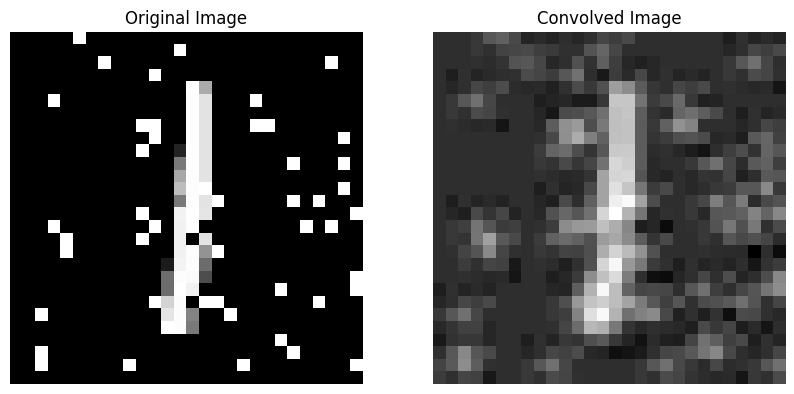

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.scipy.signal as jsp

# load the kernel from the csv file
kernel = np.loadtxt("kernel.csv", delimiter=',')
kernel = jnp.array(kernel)
print(kernel)

# load an image from the mnist dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), _ = mnist.load_data()
pic = x_train[np.random.randint(0, len(x_train))]/255.0


# add noise
num_corrupted_pixels = 100
for _ in range(num_corrupted_pixels):
    row, col = np.random.randint(0, 28), np.random.randint(0, 28)
    pic[row, col] = np.random.choice([0, 1])

# now show the image
conv_pic = jsp.convolve2d(pic, kernel, mode='same', boundary='fill')

# plot the original image with the convolved one on the side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pic, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(conv_pic, cmap='gray')
plt.title("Convolved Image")
plt.axis('off')
plt.show()


## Timing Results of the MPI implementation

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("result.csv")
print(df.head())

   run  num_of_images  num_of_processes  proc_time      time
0    1            256                32   1.839816  1.741300
1    2            256                32   1.836577  1.733909
2    3            256                32   1.493456  1.403581
3    4            256                32   3.376723  3.288035
4    5            256                32   1.508334  1.411927


In [138]:
# Extract the avreages based on the unique combinations of num_of_images and num_of_processes
averages = df.groupby(['num_of_images', 'num_of_processes']).mean()

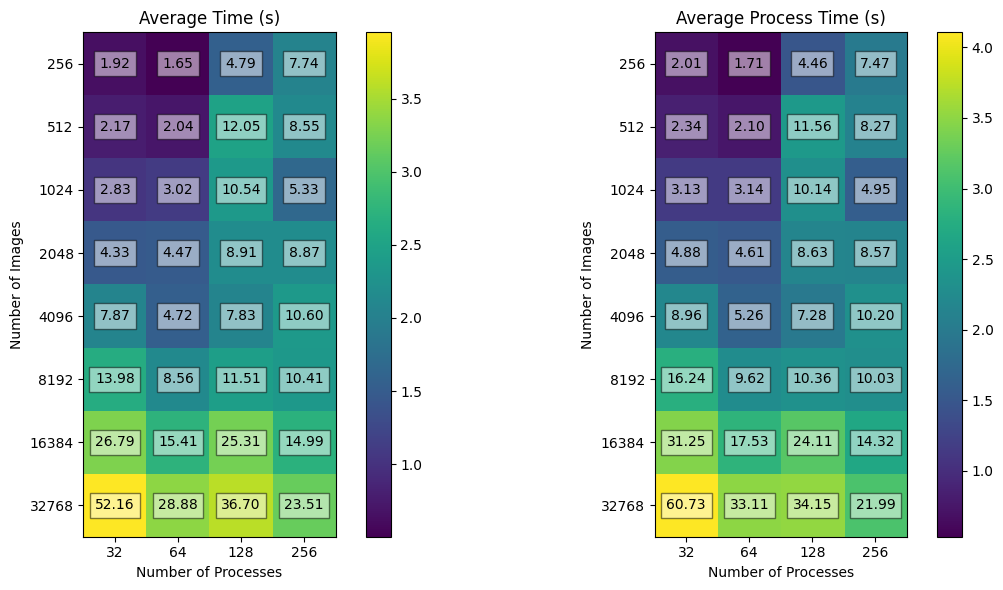

In [141]:
# plot two heatmaps side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log(averages['time'].unstack()), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Average Time (s)")
plt.xlabel("Number of Processes")
plt.ylabel("Number of Images")
plt.xticks(range(len(averages.index.levels[1])), averages.index.levels[1])
plt.yticks(range(len(averages.index.levels[0])), averages.index.levels[0])

# add labels with a white background
num_runs = len(df['run'].unique())
for i in range(len(averages.index.levels[0])):
    for j in range(len(averages.index.levels[1])):
        plt.text(j, i, f"{averages['time'].iloc[i*(num_runs-1)+j]:.2f}", ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.subplot(1, 2, 2)
plt.imshow(np.log(averages['proc_time'].unstack()), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Average Process Time (s)")
plt.xlabel("Number of Processes")
plt.ylabel("Number of Images")
plt.xticks(range(len(averages.index.levels[1])), averages.index.levels[1])
plt.yticks(range(len(averages.index.levels[0])), averages.index.levels[0])

# add labels with a white background
for i in range(len(averages.index.levels[0])):
    for j in range(len(averages.index.levels[1])):
        plt.text(j, i, f"{averages['proc_time'].iloc[i*(num_runs-1)+j]:.2f}", ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()
plt.show()
